# Prepare Antwerp LoRaWAN data

In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats as rs
import osmnx as ox
from itertools import product
from shapely import Point
from shapely.geometry import box, LineString
import rioxarray as rxr
import json

# Data source
The data can be downloaded from [zenodo](https://zenodo.org/record/3904158#.Y9ZAptJBwUE).

- Make "make_data()" functions.
- Clean the raw data, one and for all.

## Process uplink data

In [2]:
# Load Digital Elevation Model raster
dem_path = '/Volumes/Transcend/lora/data/antwerp-gis/dtm-1m-clipped.tif'
dem = rxr.open_rasterio(dem_path, masked=True).squeeze()
print(f"Loaded raster of shape {dem.shape}.")

# Make a dataframe of bounds
bbox_dem = box(*dem.rio.bounds())
dem_bounds = gpd.GeoDataFrame(geometry=[bbox_dem])
dem_bounds = dem_bounds.set_crs(dem.rio.crs)

Loaded raster of shape (10687, 12728).


In [3]:
# Load road network graph
# Use `network_type = "all"` to include walkways, etc.
# The postal vehicles do occasionally drive on service roeads and walk paths.

G = ox.graph_from_place('Antwerp, Belgium', network_type='all')

nodes, roads = ox.graph_to_gdfs(G)

roads = roads.to_crs(dem.rio.crs)

roads = roads[['geometry', 'osmid']]

print(f"Loadded {len(roads):,} road segments.")

Loadded 68,685 road segments.


In [5]:
# Load json file of uplinks
path = '../../data/antwerp/lorawan_antwerp_2019_dataset.json.txt'

# Clean data and rename columns / axis
uplinks = (pd.read_json(path)
    .drop(columns=['payload', 'counter', 'adr', 'airtime', 'dev_eui'])
    .rename(columns={'longitude':'lon_tx',
                     'latitude': 'lat_tx',
                     'dev_addr': 'dev_id'}
            )
    .rename_axis('uplink_id')
    .reset_index()
)

print(f"Loaded uplink data of shape\t{uplinks.shape}.")

# Make points for uplink locations
points_tx = [Point(xy) for xy in zip(uplinks['lon_tx'], uplinks['lat_tx'])]

uplinks = (gpd.GeoDataFrame(geometry=points_tx, data=uplinks)
           .set_crs("EPSG:4326")
           .to_crs(dem.rio.crs)
)

# Discard points not within DEM bounds
uplinks = uplinks[uplinks.within(bbox_dem)]

# Filter on small HDOP
uplinks = uplinks.query('hdop <= 1.0')


# Keep observations from devices with at least 1000 obs
devices = (uplinks['dev_id'].value_counts()[lambda x: x > 1000]
           .index
           .tolist()
)

uplinks = uplinks.query('dev_id.isin(@devices)')

# Filter on distance to road and previous observation
uplinks = (gpd.sjoin_nearest(uplinks, roads, how='left',
                             max_distance = 500,
                             distance_col='dist_to_road')
                             
            .groupby('uplink_id').first()
            .drop(columns=['index_right0', 'index_right1', 'index_right2'])
          )

uplinks['geometry_prev'] = uplinks.groupby('dev_id')['geometry'].shift(1)

uplinks['dist_from_prev'] = uplinks['geometry'].distance(uplinks['geometry_prev'])

filter = "dist_to_road < 10 & dist_from_prev > 10  & dist_from_prev < 1000"

uplinks = uplinks.query(filter)

uplinks = uplinks.drop(columns=['osmid', 'dist_to_road', 'geometry_prev', 'dist_from_prev'])

uplinks =  uplinks.reset_index(drop=True)

print(f"Retained uplink data of shape\t{uplinks.shape}.")

Loaded uplink data of shape	(130430, 8).
Retained uplink data of shape	(32071, 8).


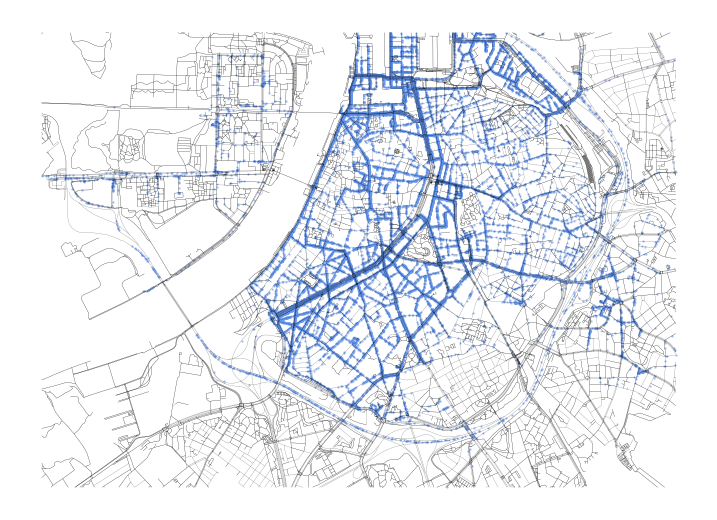

In [6]:
# Plot the loactions
fig, ax = plt.subplots(figsize=(9,9))
roads.clip(box(*uplinks.total_bounds)).plot(color='k', linewidth=0.1, ax=ax)
#dem_bounds.plot(ax=ax, alpha=0.1)
uplinks.plot(ax=ax, markersize=0.5, alpha=0.5, color='cornflowerblue')
plt.axis("off")
plt.show()

In [8]:
# Query uplink location elevation (m)
point_values = rs.zonal_stats(uplinks.geometry,
                              dem.values,
                              nodata=np.nan,
                              affine=dem.rio.transform(),
                              geojson_out=True,
                              copy_properties=True,
                              stats="min")

# make gdf from query and save attribute
point_values = gpd.GeoDataFrame.from_features(point_values)

uplinks['ele_tx'] = point_values['min'].values

uplinks['ele_tx'] += 1.5 # add dist from ground level 

## Process gateway data


In [9]:
# Load digital surface model (DSM)
dsm_path = '/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif'
dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

In [10]:
# load data
gw_path = '/Volumes/Transcend/lora/data/traffic/lorawan_antwerp_gateway_locations.json'
gateways = pd.read_json(gw_path).transpose()

print(f"Loaded data on {len(gateways):,} gateways.")

# Make points for uplink locations
points_gw = [Point(xy) for xy in zip(gateways['longitude'], gateways['latitude'])]

gateways = (gpd.GeoDataFrame(geometry=points_gw, data=gateways)
            .set_crs("EPSG:4326")
            .to_crs(dem.rio.crs)
)

gateways = gateways[gateways.within(bbox_dem)]

# Query gateway location elevation (m)
point_values = rs.zonal_stats(gateways.geometry,
                              dsm.values,
                              nodata=np.nan,
                              affine=dem.rio.transform(),
                              geojson_out=True,
                              copy_properties=True,
                              stats="max")

# make gdf from query and save attribute
point_values = gpd.GeoDataFrame.from_features(point_values)

gateways['ele_gw'] = point_values['max'].values

print(f"Retained data on {len(gateways):,} gateways.")

Loaded data on 249 gateways.
Retained data on 33 gateways.


In [11]:
gateways.head()

,latitude,longitude,geometry,ele_gw
FF0107C9,51.219257,4.413227,POINT (153106.961 212146.474),47.770000
FF010807,51.247723,4.432333,POINT (154439.111 215314.448),20.760000
08060622,51.217793,4.426748,POINT (154051.770 211984.258),6.190000
FF010605,51.199253,4.498773,POINT (159087.773 209928.028),9.150000
FF01052A,51.241821,4.449746,POINT (155655.695 214659.012),53.169998


In [ ]:
# Plot the loactions
fig, ax = plt.subplots()
roads.clip(bbox_dem).plot(color='k', linewidth=0.1, ax=ax)
uplinks.plot(ax=ax, markersize=0.25, alpha=0.2, color='cornflowerblue')
gateways.plot(ax=ax, markersize=25, color='lightpink', ec='k', lw=.5, zorder=10)
plt.axis("off")
plt.show()

In [17]:
# Expand json column to link-level data

links_good = (uplinks.reset_index()
              .rename(columns={'index':'uplink_id'})
              .explode('gateways').reset_index(drop=True)
)

json_cols = (
    pd.json_normalize(links_good['gateways'])
    .drop(columns=['rx_time.ts_type'])
    .rename(columns={'rx_time.time':'time', 'id':'gw_id'})
)

links_good = (
    pd.concat((links_good, json_cols), axis=1)
    .drop(columns=['gateways'])
)

links_good['link_id'] = list(zip(links_good.uplink_id, links_good.gw_id))

# Get uplink and gateway ids
uplink_ids = links_good['uplink_id'].unique()
gateway_ids = list(gateways.index)


# Remove links to excluded gateways (not the uplinks are retained)
links_good = links_good.query("gw_id.isin(@gateways.index)")

print(f"Derived link-level (successes only) dataframe of size {links_good.shape}.")

Derived link-level (successes only) dataframe of size (85093, 15).


In [63]:
# Make full links dataframe
df1 = pd.DataFrame({'uplink_id':uplink_ids})
df2 = pd.DataFrame({'gw_id': gateway_ids})
links = pd.merge(df1, df2, how='cross')

links['link_id'] = list(zip(links['uplink_id'], links['gw_id']))

links = links.merge(
    links_good, how='left',
    left_on='link_id',
    right_on='link_id',
    suffixes=('', '_y'))

links = links.drop(columns=['uplink_id_y', 'gw_id_y'])

links['success'] = links['rssi'].notna()

# Attach uplink data
for col in uplinks.columns:
    if col == 'gateways':
        continue
    links[f'{col}'] = links['uplink_id'].map(uplinks[col].to_dict())

links = links.rename(columns={'geometry': 'point_tx'})


# Attach gateway data
links['point_gw'] = links['gw_id'].map(gateways['geometry'].to_dict())

links['ele_gw'] = links['gw_id'].map(gateways['ele_gw'].to_dict())


# Make GeoDataFrame with links LineStrings
geometry  =  [LineString(xy) for xy in zip(links['point_tx'], links['point_gw'])]
links = gpd.GeoDataFrame(links, geometry=geometry).set_crs(dem.rio.crs)

# Remove columns
links = links.drop(columns=['point_gw', 'point_tx', 'link_id'])

print(f"Generated full link-level datframe of size {links.shape[0]:,}.")

Generated full link-level datframe of size 1,058,343.


In [64]:
# Save to file
path = '../../data/antwerp/links.geojson'
links.to_file(path, index=False, driver='GeoJSON')
